# set path

In [1]:
import os
try:
    from google.colab import drive
    drive.mount('/content/drive/', force_remount=False)

    #unpack zipped file (reading files from drive is slow)
    os.chdir('/content')
    import shutil
    print("Unzipping data... (approx 2 min)")
    shutil.unpack_archive("/content/drive/My Drive/ai-side-projects/self-supervised-halos/data/freya_postprocess.zip", "./freya_postprocess")
    print("Unzipping done")
    rootpath = '/content/freya_postprocess/'

except:
    %matplotlib inline
    rootpath = '/Users/sdbykov/work/self-supervised-halos/data/freya_postprocess/'


Mounted at /content/drive/
Unzipping data... (approx 2 min)
Unzipping done


# Imports

In [2]:
import torch

In [3]:
import torchvision

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob
from tqdm import tqdm
import time

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from torch.utils.data import TensorDataset, DataLoader



try:
    subhalos_df = pd.read_pickle('/content/drive/My Drive/ai-side-projects/self-supervised-halos/data/subhalos_df.pkl')
except:
    subhalos_df = pd.read_pickle('/Users/sdbykov/work/self-supervised-halos/data/subhalos_df.pkl')
subhalos_df['logSubhaloMass'] = np.log10(subhalos_df['SubhaloMass']*1e10/0.6774)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
if device=='cuda':
    print(torch.cuda.get_device_properties(0).name)



cuda
Tesla T4


# Data loaders and transformers

In [5]:
mass_bins = np.linspace(11, 14.7, 11) ## number of classes = len(mass_bins) - 1 = 10
mass_bins_nums = np.histogram(subhalos_df['logSubhaloMass'], bins=mass_bins)[0]
mass_bins_nums = np.log10(mass_bins_nums+1) #logarithm to make the difference between bins less pronounced
mass_bins_weights = np.max(mass_bins_nums)/mass_bins_nums
mass_bins_weights = mass_bins_weights / np.sum(mass_bins_weights)

print(f"bin weights: {mass_bins_weights}, bin counts: {mass_bins_nums}, bins: {mass_bins}")
#i think log is better weight, with linear weighting, low mass halos almost do not contribute to the loss due to small weight relative to normal halos (large mass bin is 0.1-0.5, and smallest is 4e-4).
mass_bins_weights = torch.tensor(mass_bins_weights, dtype=torch.float32)


class HaloDataset(torch.utils.data.Dataset):
    mass_bins = np.linspace(11, 14.7, 11)  # Define mass_bins globally or pass as argument

    def __init__(self, root_dir, subhalos_df,
                 load_2d=True, load_3d=False, load_mass=False,
                 DEBUG_LIMIT_FILES=None):
        self.root_dir = root_dir
        self.subhalos_df = subhalos_df
        self.files_3d = sorted(glob(root_dir +  '3d/*.npz'))
        self.files_2d = sorted(glob(root_dir + '2d/*.npz'))
        self.files_mass = sorted(glob(root_dir + 'mass/*.npz'))

        if DEBUG_LIMIT_FILES:
            self.files_3d = self.files_3d[:DEBUG_LIMIT_FILES]
            self.files_2d = self.files_2d[:DEBUG_LIMIT_FILES]
            self.files_mass = self.files_mass[:DEBUG_LIMIT_FILES]

        self.load_2d = load_2d
        self.load_3d = load_3d
        self.load_mass = load_mass


        self.halos_ids = [int(file.split('_')[-2].split('.')[0]) for file in self.files_2d]
        self.loaded_data = self.preload_data()


    def preload_data(self):
        #lesson learned: loading all data at once is faster than loading it on the fly. Before that all files were loaded for each index separately and with the inference time of 0.1 sec the data loading was 30 sec
        load_2d = self.load_2d
        load_3d = self.load_3d
        load_mass = self.load_mass

        data_dict = {}


        data_dict_3d = {}
        data_dict_mass = {}

        if load_2d:
            data_dict_2d = {}
            for file in tqdm(self.files_2d, desc='Preparing 2D data'):
                halo_id = int(file.split('_')[-2].split('.')[0])
                data = np.load(file)
                data_dict_2d[halo_id] = {
                    'map_2d_xy': data['map_2d_xy'],
                    'map_2d_xz': data['map_2d_xz'],
                    'map_2d_yz': data['map_2d_yz'],
                }
            data_dict['2d'] = data_dict_2d

        if load_3d:
            for file in tqdm(self.files_3d, desc='Preparing 3D data'):
                halo_id = int(file.split('_')[-2].split('.')[0])
                data = np.load(file)
                data_dict_3d[halo_id] = {
                    'map_3d': data['map_3d'],
                }
            data_dict['3d'] = data_dict_3d

        if load_mass:
            for file in tqdm(self.files_mass, desc='Preparing mass data'):
                halo_id = int(file.split('_')[-2].split('.')[0])
                data = np.load(file)
                data_dict_mass[halo_id] = {
                    'mass_hist': data['mass_hist'],
                    'snap': data['snap'],
                }
            data_dict['mass'] = data_dict_mass

        return data_dict

    def __len__(self):
        return len(self.halos_ids)

    def select_random_projection(self, choose_two = False):
        if not choose_two:
            return np.random.choice(['xy', 'xz', 'yz'])
        else:
            return np.random.choice(['xy', 'xz', 'yz'], 2, replace=False)


    def __getitem_2d__(self, idx):
        if not self.load_2d:
            return np.zeros(1)

        halo_id = self.halos_ids[idx]
        data_2d = self.loaded_data['2d'][halo_id]

        # Select a random projection
        selected_projections = self.select_random_projection(choose_two = True)

        selected_data = []
        for selected_projection in selected_projections:
            if selected_projection == 'xy':
                proj = np.expand_dims(data_2d['map_2d_xy'], axis=0)
            elif selected_projection == 'xz':
                proj = np.expand_dims(data_2d['map_2d_xz'], axis=0)
            elif selected_projection == 'yz':
                proj = np.expand_dims(data_2d['map_2d_yz'], axis=0)
            selected_data.append(proj)

        return (selected_data[0],selected_data[1])

    def __getitem_3d__(self, idx):
        if not self.load_3d:
            return np.zeros(1)
        halo_id = self.halos_ids[idx]
        data_3d = self.loaded_data['3d'][halo_id]
        selected_data = np.expand_dims(data_3d['map_3d'], axis=0)
        return selected_data

    def __getitem_mass__(self, idx):
        if not self.load_mass:
            return (np.zeros(1), np.zeros(1))

        halo_id = self.halos_ids[idx]
        data_mass = self.loaded_data['mass'][halo_id]
        snap = data_mass['snap']
        mass_hist = data_mass['mass_hist']
        selected_data = (snap, mass_hist)
        selected_data = np.expand_dims(selected_data, axis=0)

        return selected_data

    def __getitem_label__(self, idx):
        halo_id = self.halos_ids[idx]
        label_mass = self.subhalos_df.loc[halo_id]['logSubhaloMass']
        label_class = np.digitize(label_mass, self.mass_bins) - 1
        label = (label_mass, label_class, halo_id)
        return label


    def __getitem__(self, idx):

        data_2d = self.__getitem_2d__(idx)

        data_3d = self.__getitem_3d__(idx)

        data_mass = self.__getitem_mass__(idx)

        label = self.__getitem_label__(idx)

        result_tuple = (data_2d, data_3d, data_mass)

        return result_tuple, label


dataset = HaloDataset(root_dir = rootpath, subhalos_df=subhalos_df, load_2d=True, load_3d=False, load_mass=False)


bin weights: [0.04908683 0.0532956  0.05881324 0.06532655 0.07368349 0.08419436
 0.10160647 0.12069851 0.17917867 0.21411627], bin counts: [3.93926959 3.62818451 3.28780173 2.95999484 2.6242821  2.29666519
 1.90308999 1.60205999 1.07918125 0.90308999], bins: [11.   11.37 11.74 12.11 12.48 12.85 13.22 13.59 13.96 14.33 14.7 ]


Preparing 2D data: 100%|██████████| 16544/16544 [00:15<00:00, 1097.23it/s]


In [6]:
class FillInfWithMin:
    def __init__(self, fill_value=-np.inf):
        self.fill_value = fill_value

    def __call__(self, batch):
        # Create a mask to identify non-inf values
        mask = batch != self.fill_value

        # Compute the minimum value per image, ignoring -inf values
        min_per_image = torch.where(mask, batch, torch.inf).view(batch.size(0), -1).min(dim=1)[0]

        # Reshape min_per_image to match the dimensions of batch
        min_per_image = min_per_image.view(batch.size(0), 1, 1, 1)

        # Replace -inf values with the corresponding minimum values
        filled_batch = torch.where(batch == self.fill_value, min_per_image, batch)

        return filled_batch


img_transform= transforms.Compose([
    transforms.RandomResizedCrop(size=(64, 64), scale=(0.7, 0.99)),
    transforms.RandomRotation(degrees=180, fill=-np.inf),
    FillInfWithMin(fill_value=-np.inf)  # Custom transform to fill -inf with min per image
])


In [7]:
def time_data_loading(dataloader, model = None, transform = None):
    t = time.time()
    n = len(dataloader)
    for i, (data, label) in enumerate(dataloader):
        projections = data[0][0]

        if transform is not None:
            input_img = transform(projections)
        else:
            input_img = projections

        input_img = input_img.to(device)

        label = label[1].to(device)

        if model is not None:
            model(input_img)

    print(f'{n} batches loaded in {time.time() - t:.2f} sec. {batch_size=}; inference={model is not None}; transform={transform is not None}')



# Initialize dataset and dataloader

if device=='cpu':
    batch_size = 128
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
else:
    print('dataloader on gpu')
    batch_size = 512
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers = 2)

time_data_loading(dataloader)
time_data_loading(dataloader, transform=img_transform)

dataloader on gpu
33 batches loaded in 3.88 sec. batch_size=512; inference=False; transform=False
33 batches loaded in 5.43 sec. batch_size=512; inference=False; transform=True


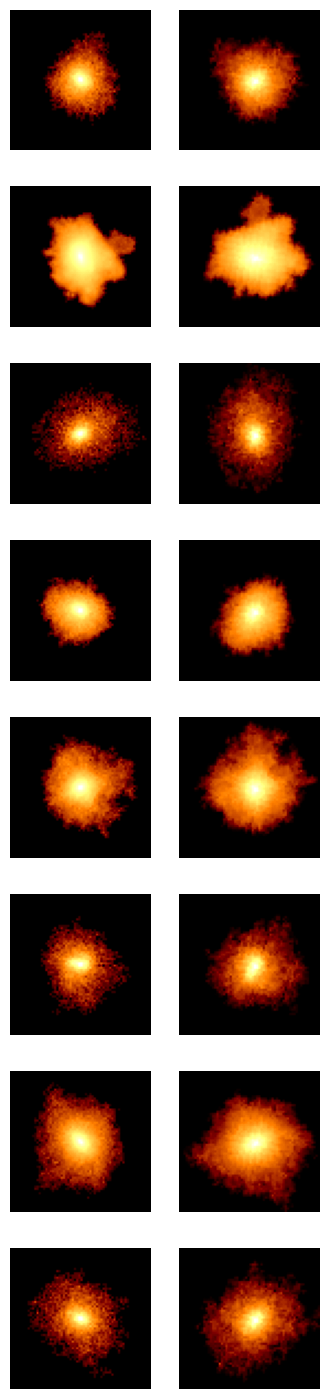

In [8]:
batch_test_data, _ = next(iter(dataloader))
batch_test_data = batch_test_data[0][0]
batch_test_data_trans = img_transform(batch_test_data)

fig, axs = plt.subplots(8, 2, figsize=(4, 18))

for i in range(8):
    axs[i, 0].imshow(batch_test_data[i][0].cpu().numpy(), cmap='afmhot')
    axs[i, 1].imshow(batch_test_data_trans[i][0].cpu().numpy(), cmap='afmhot')
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')


# Contrastive learning model

## Contrastive loss

In [9]:

class SupConLoss(nn.Module): #TODO check/test this loss
    #src: https://github.com/giakoumoglou/classification/tree/main/notebooks
    #if no labels are provided, it is basically the SimCLRLoss #TODO check this with SimCLRLoss class
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07,
                 device = 'cpu'):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

        self.device = device

    def forward(self, features, labels=None, mask=None):

        device = self.device

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss



## Model

In [36]:
class Encoder(nn.Module):

    "Encoder network"
    def __init__(self):
        super(Encoder, self).__init__()

        image_channels = 1
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),
            nn.Linear(128, 64),
            nn.Linear(64, 64),)

    def forward(self, x):
        return self.encoder(x)

class ProjectionHead(nn.Module):
    "Projection head"
    def __init__(self, input_dim=64, hidden_dim=64, output_dim=64):
        super(ProjectionHead, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.projection_head(x)


class SupCon(nn.Module):
    """encoder + projection head"""
    def __init__(self, encoder, head):
        super(SupCon, self).__init__()
        self.encoder = encoder
        self.head = head

    def forward(self, x):
        x = self.encoder(x)
        x = F.normalize(self.head(x), dim=1)
        return x




def contrastive_train_step(
        epoch,
        model,
        criterion,
        optimizer,
        scheduler,
        dataloader,
        history=None,
        device='cpu',
        ):

    model.train()

    running_loss = 0.0

    for i, (batch_data, batch_label) in enumerate(dataloader):
        batch_size = batch_data[0][0].shape[0]
        batch_label = batch_label[1].to(device)

        image_1 = batch_data[0][0].to(device)
        image_2 = batch_data[0][1].to(device)
        view_1 = img_transform(image_1)
        view_2 = img_transform(image_2)


        data = torch.cat([view_1, view_2], dim=0)
        data = data.to(device)

        features = model(data)

        f1, f2 = torch.split(features, [batch_size, batch_size], dim=0)
        features = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)

        loss = criterion(features, labels=batch_label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step() if scheduler is not None else None

        running_loss += loss.item()

    running_loss /= len(dataloader)
    #print(f'Epoch {epoch}, loss: {running_loss}')

    if history is not None:
        history['loss'].append(running_loss)

    return running_loss


def contrastive_train(epochs,
                 model,
                 criterion,
                 optimizer,
                 scheduler,
                 dataloader,
                 history=None,
                 device = 'cpu'):

    pbar = tqdm(range(epochs))

    history = {'loss': [], 'val_loss': []} if history is None else history

    try:
        for epoch in pbar:
            loss = contrastive_train_step(
                epoch,
                model,
                criterion,
                optimizer,
                scheduler,
                dataloader,
                history=history,
                device=device
            )
            pbar.set_postfix({'loss': loss})

    except KeyboardInterrupt:
        print('Interrupted')

    return history



In [37]:
lr = 5e-3
temperature = 0.07


encoder = Encoder().to(device)
head = ProjectionHead().to(device)
model = SupCon(encoder=encoder, head = head).to(device)



criterion = SupConLoss(temperature=temperature, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [38]:

if device=='cpu':
    batch_size = 128
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
else:
    print('dataloader on gpu')
    batch_size = 512
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers = 2)



data, label = next(iter(dataloader))
data = data[0]
label = label[1]

input = data[0].to(device)
encoded = model.encoder(input)
output = model.head(encoded)

output_model = model(input)

print(f'{input.shape=}, {encoded.shape=}, {output.shape=}, {output_model.shape=}')

dataloader on gpu
input.shape=torch.Size([512, 1, 64, 64]), encoded.shape=torch.Size([512, 64]), output.shape=torch.Size([512, 64]), output_model.shape=torch.Size([512, 64])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


In [39]:
n_epochs = 50

history = contrastive_train(n_epochs,
                       model,
                       criterion,
                       optimizer,
                       scheduler=scheduler,
                        dataloader=dataloader,
                        device=device)



 16%|█▌        | 8/50 [00:42<03:41,  5.26s/it, loss=6.03]

Interrupted


{'loss': [6.25938792662187, 6.044479601310961, 6.02916838906028, 6.029316064083215, 6.032779953696511, 6.031695120262377, 6.033034093452223, 6.030664805209998], 'val_loss': []}


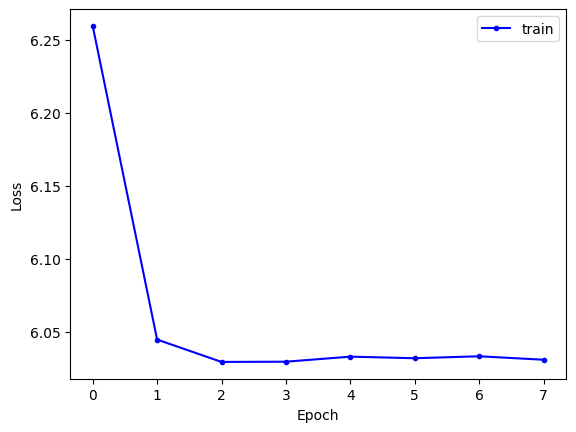

In [40]:
print(history)
plt.plot(history['loss'], 'b.-', label='train')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


----